# Find your Celebrity Twin!

Artificial intelligence and its subcategory machine learning, are one of the hottest topics in technology this moment. It is the field that sparks fear, admiration and fascination in us at the same time, so I chose the topic based on the theme I find the most shocking or concerning – face recognition. 

We all know big companies are gathering data about us and they track our every move, but do we really realize what that means? Like they say: ‘The picture tells more then 1000 words!’, the results of this project shocked me, because gathering data got entirely different dimension for me. Only one image of our face is enough that we can get identified from images, group images or even videos. 

The idea started with finding dataset with over 200.000 images of famous people with 10,177 unique identities, but names of identities are not given. Dataset also includes 40 binary attribute annotations per image and 5 landmark locations.

Unsupervised machine learning – clustering.

Attribute model

The number of features must be fixed in advance. However it can be very high dimensional (e.g. millions of features) with most of them being "zeros" for a given sample. This is a case where scipy.sparse matrices can be useful, in that they are much more memory-efficient than NumPy arrays.
As we recall from the previous section (or Jupyter notebook), we represent samples (data points or instances) as rows in the data array, and we store the corresponding features, the "dimensions," as columns.


In [32]:
#Importing dependencies

import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import os
from sklearn import svm
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
import time
import numpy as np 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Adding allowed extention for photos
ALLOWED_EXTENSIONS_IMAGES = {'png', 'jpg', 'jpeg'}
#Adding allowed extention for encodings
ALLOWED_EXTENSIONS_ENCODING = {'txt'}

## Setting Train Model

In [33]:
# Encoding 128 dots on faces found in photos

X = []
y = []


train_data = "./faces/train"
encode_data = "./faces/encode"

all_encodings_paths = []
i = 0

for id_folder in os.listdir(train_data):
    #if it's not a sub folder with id number, skip and continue
    if not os.path.isdir(os.path.join(train_data, id_folder)):
        continue
    
    #if encoding path is not ending with '.txt', continue
    for encoding_path in image_files_in_folder(os.path.join(encode_data, id_folder)):
        if os.path.splitext(encoding_path)[1][1:] not in ALLOWED_EXTENSIONS_ENCODING:
            continue
        
        
        all_encodings_paths.append(encoding_path)
        #open id_folder and read files
        file = open(encoding_path, "r") 
        #getting id_folder number
        d = encoding_path.split("/")[-2]
        #get encodings for each file and put it in arrays
        dx = np.array(file.read().split(",")).astype(np.float64)
        # 128 face encodings
        X.append(dx)
        # file names
        y.append(d)
        file.close()
        i += 1
    
    if i > 10000:
        break

print(len(all_encodings_paths))

10020


In [34]:
#splitting data with sklearn train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0 )

In [35]:
#can I put here just X train and X test, because y is just the name of the file?

k: 1, Train/Test Score: 1.000/0.949
k: 3, Train/Test Score: 1.000/0.952
k: 5, Train/Test Score: 1.000/0.949
k: 7, Train/Test Score: 1.000/0.947
k: 9, Train/Test Score: 1.000/0.943
k: 11, Train/Test Score: 1.000/0.939
k: 13, Train/Test Score: 1.000/0.936
k: 15, Train/Test Score: 1.000/0.933
k: 17, Train/Test Score: 1.000/0.927
k: 19, Train/Test Score: 1.000/0.922


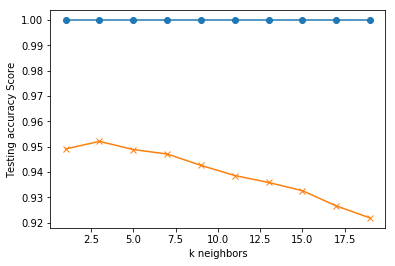

In [36]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []

for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='ball_tree', weights='distance')
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [37]:
#Precission
trained_model = knn.fit(X_train, y_train)
trained_model.score(X, y)

0.9686626746506986

In [40]:
#Setting train model 
#Trains a k-nearest neighbors classifier for face recognition
def train(train_data="./faces/encode", model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=True):
    X = []
    y = []

    all_encodings_paths = []
    for id_folder in os.listdir(train_data):
        if not os.path.isdir(os.path.join(train_data, id_folder)):
            continue

        for encoding_path in image_files_in_folder(os.path.join(encode_data, id_folder)):
            if os.path.splitext(encoding_path)[1][1:] not in ALLOWED_EXTENSIONS_ENCODING:
                continue

            all_encodings_paths.append(encoding_path)
            file = open(encoding_path, "r") 
            d = encoding_path.split("/")[-2]
            dx = np.array(file.read().split(",")).astype(np.float64)
            X.append(dx)
            y.append(d)
            file.close()

    print(len(all_encodings_paths))
    
    #Setting train model - trains a k-nearest neighbors classifier for face recognition

    # Create and train the KNN classifier
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf

In [41]:
# Training data
if __name__ == "__main__":
    print("Training KNN classifier...")
    classifier = train("./faces/encode", model_save_path="trained_knn_model.clf", n_neighbors=3)
    print("Training complete!")

Training KNN classifier...
196694
Training complete!


## Prediction Model - Celebrity Match

In [43]:
#Setting prediction model

def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):

    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS_IMAGES:
        raise Exception("Invalid image path: {}".format(X_img_path))
    
    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations in the image
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=3)    
    are_matches = []
    for i in range(len(X_face_locations)):
        print(closest_distances[0][i][0])
        are_matches.append(closest_distances[0][i][0] <= distance_threshold)
        
    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]


In [44]:
#Showing the face recognition results on the image
def show_prediction_labels_on_image(img_path, predictions):
  
    pil_image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(pil_image)

    for name, (top, right, bottom, left) in predictions:
        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        # There's a bug in Pillow where it blows up with non-UTF-8 text
        # when using the default bitmap font
        name = name.encode("UTF-8")

        # Draw a label with a name below the face
        text_width, text_height = draw.textsize(name)
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))

    # Remove the drawing library from memory as per the Pillow docs
    del draw

    # Display the resulting image
    pil_image.show()

In [47]:
if __name__ == "__main__":
    # Using the trained classifier, make predictions for unknown images
    for image_file in os.listdir("./faces/test"):
        full_file_path = os.path.join("./faces/test", image_file)

        print("Looking for faces in {}".format(image_file))

        # Find all people in the image using a trained classifier model
        # Note: You can pass in either a classifier file name or a classifier model instance
        predictions = predict(full_file_path, model_path="trained_knn_model.clf")

        # Print results on the console
        for name, (top, right, bottom, left) in predictions:
            print("- Found {} at ({}, {})".format(name, left, top))

        # Display results overlaid on an image(rm ./faces/test/DS...)
        show_prediction_labels_on_image(os.path.join("./faces/test", image_file), predictions)


Looking for faces in 7cwSSZJA.jpg
0.4980958050192508
- Found 1878 at (7cwSSZJA.jpg, 43)
Looking for faces in 1366_v9_bb.jpg
0.5308956890980153
- Found 4899 at (1366_v9_bb.jpg, 428)
Looking for faces in tmp6boni0ss copy.png
0.47844539674331427
- Found 8240 at (tmp6boni0ss copy.png, 1380)
Looking for faces in aaron-paul-435-63.jpg
0.29975917611213315
- Found 18 at (aaron-paul-435-63.jpg, 110)
Looking for faces in tmp6i_64do3 copy.png
0.5079050665259941
- Found 6509 at (tmp6i_64do3 copy.png, 1125)
